<div style="width: 100%; clear: both;">
    <div style="float: left; width: 50%;">
        <img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
    </div>
</div>
<div style="float: right; width: 50%;">
    <p style="margin: 0; padding-top: 22px; text-align:right;">M2.876 · Análisis de grafos y redes sociales</p>
    <p style="margin: 0; text-align:right;">Máster universitario en Ciencias de Datos (<i>Data Science</i>)</p>
    <p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
<div style="width: 100%; clear: both;"></div>
<div style="width:100%;">&nbsp;</div>

# Predicción de enlaces utilizando *graph neural networks* (GNN)

En este ejemplo vamos a utilizar redes neuronales para codificar la información topológica de la red y la información relativa a los nodos para entrenar un modelo que sea capaz de predecir los nodos de una red. 

Pueden aparecer conceptos transversales entre *complex networks* y *deep learning*. Se recomienda revisar la bibliografía y los enlaces que se proporcionan a lo largo de la actividad:

* https://github.com/pyg-team/pytorch_geometric
* https://www.deeplearningbook.org/

## Instalación de librerías

Se recomienda ejecutar esta PEC en un entorno virtual. 

**Nota**: en ocasiones, la librería `torch` puede ser difícil de instalar debido a las fuertes dependencias que tiene. Se proporcionan las instrucciones para instalar estas librerías en un entorno [Google Colab](https://colab.research.google.com/).

In [ ]:
# Run this code in colab environment 
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 9.4 MB 43.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 4.6 MB 28.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 3.2 MB 23.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-49apy9sl
  Running command git clone -q https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-49apy9sl
     |███████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.6 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


## Carga de librerías

En la siguiente celda se deben cargar todas las librerías necesarias para ejecutar la actividad.

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import scipy.sparse as sp
import json
import collections
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
from sklearn.metrics import roc_auc_score
from torch_geometric.transforms import RandomLinkSplit

import random

## Parte 1. Carga de *features* para utilizarlos en PyG

En este apartado vamos a explorar las redes neuronales en grafos utilizando la librería `PyG`. Esta librería está, en parte, basada en Pytorch y Networkx, así que su conocimiento nos facilitará la tarea. 

En primer lugar, cargaremos el fichero `json` que contiene los *features* de cada nodo. La descripción es numérica y hace referencia a una lista que no se ha proporcionado ni es necesaria. Cada nodo tendrá una serie de números asociados, por ejemplo:
> `"836": [1521, 1234, 12]`

Esto indica que el nodo 836 tiene asociadas las características: 1521, 1234, 12.

A continuación, enumeramos los pasos que vamos a realizar:

1. Cargaremos los _features_ mediante el algoritmo _one hot encoding_ para obtener una matriz de `numpy` con dimensiones 4648x2148, donde 4648 corresponde al número de nodos totales, mientras que 2148 corresponde al número total de posibles features. 
- La matriz tendrá un 1 si el nodo *x* tiene el *feature* B y será 0 en el resto de los casos.

2. Utilizaremos la función [Data](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) para obtener el objeto `data`. 
- Para ello tendremos que utilizar `edge_index` en el formato adecuado mediante la función proporcionada `get_edge_index_from_G`.

3. Utilizaremos la función `to_networkx` para obtener un grafo de NetworkX (con atributos en los nodos) gracias al objeto creado en el apartado anterior. Utilizaremos este grafo y la función [from_networkx](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html?highlight=from_networkx#torch_geometric.utils.from_networkx) para generar un objeto grafo de la librería PyG.

4. La librería PyG siempre considera los grafos como dirigidos (aunque el grafo del ejercicio es no dirigido).

* El resultado debe ser un objeto de la forma:
> `Data(x=[4648, 2148], edge_index=[2, 118764])`

**Bibliografía**:
* One hot encoding. https://www.educative.io/blog/one-hot-encoding

In [ ]:
def get_edge_index_from_G(g):
  a = []
  b = []
  for item in g.edges:
    a.append(int(item[0]))
    b.append(int(item[1]))
  return torch.tensor([a,b])

In [ ]:
f = open("data/ES_features.json") 
dict_features = json.load(f) # This is a dictionary with features of each node
f.close()

# Sort dictionary by key
dict_features = collections.OrderedDict(sorted(dict_features.items()))

# We do one hot enconding
# First we get the number of total features we have
lol = list(dict_features.values()) # Convert dict to list of list
result = sum(lol, []) # Join the lists
number_of_features = max(set(result)) # Get the max number in features
number_nodes = nx.number_of_nodes(G)
# Now we do one hot encoding
mat = sp.dok_matrix((number_nodes, number_of_features+1), dtype=np.int8) # Build empty matrix

# It is 1 if feature is present
for user_id, feature in dict_features.items():
    mat[int(user_id), feature] = 1.0

# Convert to full array
mat = mat.toarray()
mat = mat.astype("double")
print("Shape of matrix: {}".format(mat.shape))

# Due to the process of build the matrix some columns are zero, we can just delete them:
idx = np.argwhere(np.all(mat[..., :] == 0, axis=0))
mat = np.delete(mat, idx, axis=1)
print("Shape of matrix: {}".format(mat.shape))
mat

Shape of matrix: (4648, 3170)
Shape of matrix: (4648, 2148)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
edge_index = get_edge_index_from_G(G)
data_grafo = Data(edge_index=edge_index, x=mat)

In [ ]:
H = to_networkx(data_grafo, node_attrs=['x'])
H = H.to_undirected() # TO undirected graph
graph = from_networkx(H)
graph.x = graph.x.type(torch.FloatTensor) # Set proper unit

In [ ]:
# DGL GRAPH IS ALWAYS DIRECTED SO THE NUMBER OF EDGES HAVE BEEN DUPLICATED
graph

Data(x=[4648, 2148], edge_index=[2, 118764])

## Parte 2. Dividir el grafo en *train*, *test* y validación

Necesitaremos dividir el grafo en *train*, *test* y validación. Sin embargo, para el caso de las redes neuronales en grafos existen algunas particularidades especiales. 

La primera es que la red no se entrenará únicamente con la topología de la red, sino que se entrenará con: 
* Los *features* de los nodos.
* Los enlaces entre nodos.
* Otros enlaces negativos que crearemos y que son ejemplos de enlaces que no existen. De esa forma, la red aprenderá a diferenciar ejemplos positivos (enlaces que existen) de ejemplos negativos (enlaces inexistentes) en función de las características de los nodos. 

En esta parte: 

1. Dividiremos utilizando la función [RandomLinkSplit](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomLinkSplit) y dejaremos un 5 % de los enlaces para validación y un 10 % de los enlaces para *test*. 
* Añadiremos enlaces negativos para el *train* con proporción 1. 
* Crearemos tres nuevos objetos: `train_data`, `val_data` y `test_data`.

2. Exploraremos los objetos anteriores y justificaremos las dimensiones de sus variables: `x`, `edge_index`, `edge_label` y `edge_label_index`.

**Bibliografía**:

Se recomienda leer los siguientes enlaces para responder a los dos apartados anteriores:
* https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomLinkSplit
* https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275
* https://www.youtube.com/watch?v=GAOHM1rVUdw

In [ ]:
# For this part please use:
# Validation edges = 0.05
# Test edges = 0.1
# set is_undirected to True to avoid negative reverse links
# Add negative train samples during the split with a ratio of 1

split = RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=True,
    neg_sampling_ratio=1,
)
train_data, val_data, test_data = split(graph)

In [ ]:
# Please explore the graph before and after the partitions and explain the numbers you are getting 
print("Original graph is {}: ".format(graph))
print("Train graph is {}: ".format(train_data))
print("Validation graph is {}: ".format(val_data))
print("Test graph is {}: ".format(test_data))

Original graph is Data(x=[4648, 2148], edge_index=[2, 118764]): 
Train graph is Data(x=[4648, 2148], edge_index=[2, 100950], edge_label=[100950], edge_label_index=[2, 100950]): 
Validation graph is Data(x=[4648, 2148], edge_index=[2, 100950], edge_label=[5938], edge_label_index=[2, 5938]): 
Test graph is Data(x=[4648, 2148], edge_index=[2, 106888], edge_label=[11876], edge_label_index=[2, 11876]): 


## Parte 3. Entrenar un modelo de GNN *autoencoder*

En este apartado se introduce un modelo de red neuronal compuesto por dos [GCN Convolucionales](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv).

A continuación, veremos cómo:

1. Completar la función `model` para iniciar el modelo, donde:
  - _in channels_ corresponde al número de *features*, 
  - _hidden channels_ se utilizará 16 y
  - _out channels_ se empleará el valor 8.

2. Entrenar durante treinta épocas la red neuronal. En cada época mostrar el *loss* en *train*, el ROC AUC *score* en validación y en *test*.

3. Representar los valores anteriores (*loss*, ROC AUC de val y *test*) en una gráfica temporal donde el eje *x* es el número de épocas.

In [ ]:
## FUNCION PRORPORCIONADA
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    out = model.decode(z, train_data.edge_label_index).view(-1)
    loss = criterion(out, train_data.edge_label)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# INICIAR LA RED
model = Net(graph.num_features, 16, 8).to("cpu")
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
model.encode(train_data.x, train_data.edge_index)

tensor([[ 0.0409, -0.0120,  0.0132,  ..., -0.0455,  0.0032,  0.0103],
        [ 0.0670, -0.0237,  0.0247,  ..., -0.1129, -0.0028, -0.0033],
        [ 0.0537, -0.0027,  0.0414,  ..., -0.0914, -0.0067,  0.0076],
        ...,
        [ 0.0748, -0.0146,  0.0371,  ..., -0.0801,  0.0047,  0.0358],
        [ 0.0810, -0.0072,  0.0463,  ..., -0.1060,  0.0015,  0.0354],
        [ 0.0774, -0.0036,  0.0341,  ..., -0.1086,  0.0264,  0.0247]],
       grad_fn=<AddBackward0>)

In [ ]:
# Now we can train the model with train and val
# OJO, creo que se produce overfitting porque la gente va variando el negative sampling para evitar esto
loss_epoch =  []
val_list = []
test_list = []
best_val_auc = final_test_auc = 0
num_epocs = 30
for epoch in range(num_epocs):
  loss = train()
  loss_epoch.append(float(loss.detach()))
  val_auc = test(val_data) # AUC of Validation
  val_list.append(val_auc)
  test_auc = test(test_data) # AUC of test data
  test_list.append(test_auc)
  if val_auc > best_val_auc:
      best_val = val_auc
      final_test_auc = test_auc
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, 'f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

Epoch: 000, Loss: 0.6845, Val: 0.8934, Test: 0.8927
Epoch: 001, Loss: 0.6760, Val: 0.8951, Test: 0.8941
Epoch: 002, Loss: 0.6649, Val: 0.8961, Test: 0.8948
Epoch: 003, Loss: 0.6518, Val: 0.8968, Test: 0.8954
Epoch: 004, Loss: 0.6379, Val: 0.8973, Test: 0.8958
Epoch: 005, Loss: 0.6246, Val: 0.8978, Test: 0.8962
Epoch: 006, Loss: 0.6138, Val: 0.8983, Test: 0.8966
Epoch: 007, Loss: 0.6071, Val: 0.8987, Test: 0.8970
Epoch: 008, Loss: 0.6053, Val: 0.8991, Test: 0.8973
Epoch: 009, Loss: 0.6077, Val: 0.8994, Test: 0.8976
Epoch: 010, Loss: 0.6117, Val: 0.8997, Test: 0.8979
Epoch: 011, Loss: 0.6144, Val: 0.9000, Test: 0.8982
Epoch: 012, Loss: 0.6145, Val: 0.9002, Test: 0.8984
Epoch: 013, Loss: 0.6122, Val: 0.9004, Test: 0.8987
Epoch: 014, Loss: 0.6085, Val: 0.9006, Test: 0.8989
Epoch: 015, Loss: 0.6045, Val: 0.9008, Test: 0.8991
Epoch: 016, Loss: 0.6010, Val: 0.9009, Test: 0.8992
Epoch: 017, Loss: 0.5985, Val: 0.9011, Test: 0.8994
Epoch: 018, Loss: 0.5972, Val: 0.9012, Test: 0.8996
Epoch: 019, 

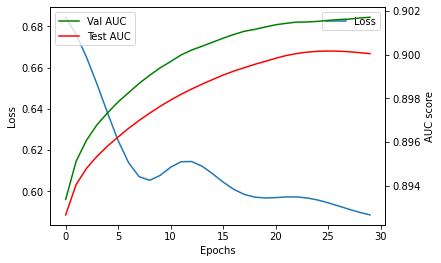

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(num_epocs), loss_epoch, label="Loss")
ax2 = ax.twinx()

ax2.plot(range(num_epocs), val_list, label="Val AUC", c="g")
ax2.plot(range(num_epocs), test_list, label="Test AUC", c="r")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2.set_ylabel("AUC score")

ax.legend()
ax2.legend()

## Parte 4. Realizar una predicción sobre los enlaces

Vamos a comprobar la bondad del modelo en la predicción de enlaces. 

Seguiremos los siguientes pasos:

1. Tomaremos `test_data` y guardaremos en una matriz los enlaces de esta matriz. Tendremos en cuenta que `est_data.edge_index_label` indica si esos enlaces son positivos o negativos, mientras que `test_data.edge_index` contiene todos los enlaces (positivos y negativos). Únicamente nos interesan los positivos.

2. Utilizaremos el código proporcionado con la matriz de adyacencia predecida por el modelo para predecir los enlaces más probables. Comprobad cuántos enlaces positivos tiene la matriz *test* y obtened X enlaces más probables predecidos por la matriz de adyacencia. Aquí X es el número de enlaces de test. Obtened una métrica de *accuracy*.

Hay que tener en cuenta dos cosas importantes al predecir sobre la matriz de adyacencia:
* Eliminar *self-loops*.
* Eliminar los enlaces duplicados, ya que la predicción de la red será como si fuera no-dirigida.

In [ ]:
# Para hacer esto, metemos en el encoder los features de test_data.x y también los edge_index de test data.
z = model.encode(test_data.x, test_data.edge_index)
prob_adj = z @ z.t().sigmoid() # get adj NxN

In [ ]:
## 1. Enlaces positivos
enlaces_verdaderos = []
enlaces_origin = []
enlaces_destino = []
for i, item in enumerate(test_data.edge_label):
  if item == 1:
    a = test_data.edge_index[0][i].item()
    b = test_data.edge_index[1][i].item()
    if a < b :
      enlaces_verdaderos.append((a,b))
    else:
      enlaces_verdaderos.append((b,a))
    enlaces_origin.append(test_data.edge_index[0][i])
    enlaces_destino.append(test_data.edge_index[1][i])

enlaces_positivos_test = torch.tensor([enlaces_origin, enlaces_destino])
print(enlaces_positivos_test)
print(enlaces_positivos_test.shape)
print(enlaces_verdaderos)

tensor([[2499, 1687,  787,  ...,  223, 1264, 3047],
        [3222, 2239, 1066,  ..., 2388, 2874, 3173]])
torch.Size([2, 5938])
[(2499, 3222), (1687, 2239), (787, 1066), (332, 3126), (2468, 2677), (1481, 3323), (627, 3034), (419, 3017), (2677, 3790), (3261, 4173), (3367, 4271), (596, 3230), (1084, 4477), (2533, 3559), (3056, 3075), (1819, 3328), (1819, 2741), (1577, 2523), (87, 1535), (457, 899), (1438, 2643), (497, 3552), (3656, 3667), (351, 499), (1819, 3349), (2674, 3404), (2885, 2964), (815, 2922), (3691, 4467), (1285, 2530), (394, 1009), (562, 1912), (351, 3199), (1791, 2764), (2011, 2278), (2408, 2429), (1988, 3074), (838, 3572), (2372, 4617), (291, 2769), (308, 1890), (218, 718), (3341, 4421), (1890, 2841), (596, 2953), (2353, 4493), (1318, 1527), (518, 1861), (1728, 4603), (105, 1585), (312, 4217), (1376, 3340), (2591, 2864), (789, 2804), (12, 904), (1657, 3830), (982, 2195), (809, 2433), (222, 2627), (1920, 4331), (223, 2558), (2090, 3719), (1486, 1931), (2754, 3316), (2202, 41

In [ ]:
# REMOVE SELF-LOOPS
for i in range(prob_adj.shape[0]):
  prob_adj[i][i] = 0

In [ ]:
prob_adj

tensor([[0.0000, 0.0863, 0.0872,  ..., 0.0972, 0.1077, 0.0989],
        [0.0203, 0.0000, 0.0403,  ..., 0.0567, 0.0751, 0.0600],
        [0.1050, 0.1242, 0.0000,  ..., 0.1423, 0.1609, 0.1454],
        ...,
        [0.1448, 0.1705, 0.1722,  ..., 0.0000, 0.2208, 0.1999],
        [0.1673, 0.2012, 0.2031,  ..., 0.2333, 0.0000, 0.2388],
        [0.1380, 0.1653, 0.1669,  ..., 0.1914, 0.2179, 0.0000]],
       grad_fn=<CopySlices>)

In [ ]:
# La pasamos a numpy
np_adj = prob_adj.detach().numpy()

In [ ]:
# Generamos los enlaces (this takes a lot). Probabelemente se puede hacer de forma más eficiente usando numpy.argpartition
enlaces_predecidos = []
for i in range(5938):
  (a,b) = np.where(np_adj == np.amax(np_adj))
  a = int(a[0])
  b = int(b[0])
  if a<b:
    enlaces_predecidos.append((a, b))
  else:
    enlaces_predecidos.append((b, a))
  np_adj[a][b] = 0

In [ ]:
# Contar cuántos de los enlaces predecidos están realmente en el test.
enlaces_true_predicted = 0

for item in enlaces_predecidos:
  if item in enlaces_verdaderos:
    enlaces_true_predicted+=1

In [ ]:
# Accuracy 
accuracy = enlaces_true_predicted/len(enlaces_predecidos)
print("Acuracy: {} %".format(accuracy*100))

Acuracy: 3.0481643651060963 %
